In [51]:
import torch
import numpy as np
import torch.autograd as autograd
import torch.nn as nn
from torch.optim import Adam
import tqdm
import matplotlib.pyplot as plt



class ToyMLP(nn.Module):
    def __init__(self,d):
        super().__init__()
        hidden_unit=32
        self.d=d
        self.net=nn.Sequential(
            nn.Linear(d,hidden_unit,bias=True),
            nn.Softplus(),
            nn.Linear(hidden_unit,hidden_unit,bias=True),
            nn.Softplus(),
            nn.Linear(hidden_unit,hidden_unit,bias=True),
            nn.Softplus(),
            nn.Linear(hidden_unit,hidden_unit,bias=True),
            nn.Softplus(),
            nn.Linear(hidden_unit,d,bias=False),
        )
    def forward(self,x):
        return  self.net(x)


def single_sliced_score_matching(score_net, samples, noise=None, noise_type='radermacher'):
    samples.requires_grad_(True)
    if noise is None:
        vectors = torch.randn_like(samples)
        if noise_type == 'radermacher':
            vectors = vectors.sign()
        elif noise_type == 'sphere':
            vectors = vectors / torch.norm(vectors, dim=-1, keepdim=True) * np.sqrt(vectors.shape[-1])
        elif noise_type == 'gaussian':
            pass
        else:
            raise ValueError("Noise type not implemented")
    else:
        vectors = noise

    grad1 = score_net(samples)
    gradv = torch.sum(grad1 * vectors)
    loss1 = torch.sum(grad1 * vectors, dim=-1) ** 2 * 0.5
    grad2 = autograd.grad(gradv, samples, create_graph=True)[0]
    loss2 = torch.sum(vectors * grad2, dim=-1)


    loss = (loss1 + loss2).mean()
    return loss



In [52]:
device = 'cuda:3' #@param ['cuda', 'cpu'] {'type':'string'}
n_epochs=100
lr=0.01
# data=torch.randn(10000,1).to(device)
data1=torch.randn(5000,1).to(device)-3 
data2=torch.randn(5000,1).to(device)+3 
data = torch.cat((data1, data2), dim=0).to(device)
score_net=ToyMLP(d=1).to(device)
optim = Adam(score_net.parameters(), lr=lr)

tqdm_epoch = tqdm.trange(n_epochs)
for epoch in tqdm_epoch:
    
    optim.zero_grad()

    loss=single_sliced_score_matching(score_net, data)
    tqdm_epoch.set_description('Loss: {:5f}'.format(loss.detach().cpu() ))

    loss.backward()
    optim.step()


Loss: 0.000207:   0%|          | 0/100 [00:00<?, ?it/s] 

Loss: -0.462284: 100%|██████████| 100/100 [00:00<00:00, 179.41it/s]


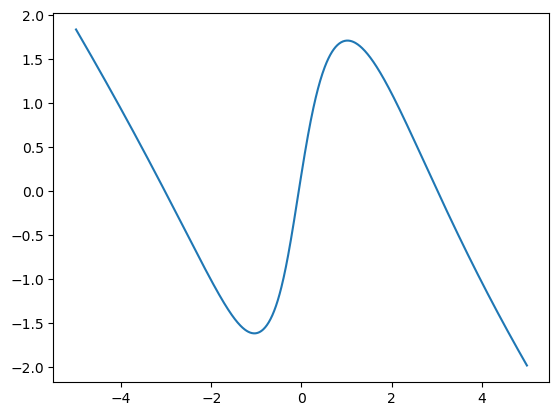

In [53]:
x_space=torch.linspace(-5,5,1000).view(-1,1).to(device)
score_x=score_net(x_space)
plt.plot(x_space.detach().cpu().numpy(),score_x.detach().cpu().numpy())